In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
import os
import pickle
import importlib
import detect_bursts
importlib.reload(detect_bursts)
import copy
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans

from collections import defaultdict

Loading ALdata

In [3]:
def convertIntoFloatList(str):
    #preprocess data extracted
    #remove the "[" and "]" characters
    str = str[1:-1]
    if str == '':
        return None
    return np.array(str.split(','),dtype = float)

def readData(frame,mothName):
    #convert dataframe rows into an entire list
    tp = []
    nameArr = []
    for ind in frame.index:
        inc = convertIntoFloatList(frame[ind])
        if inc is not None:
            tp.append(inc)
            nameArr.append(mothName)
    return tp,nameArr

#load xlsx data, extract column with largest pre_stim
def argMaxPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMaxColName = df.columns[np.argmax(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMaxColName}##########")
    return argMaxColName

#load xlsx data, extract column with smallest pre_stim
def argMinPreStim(mothNum):

    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/timestamps_{mothNum}.csv'

    df = pd.read_csv(loadPath,header=0)

    argMinColName = df.columns[np.argmin(df.iloc[0][2:]) + 2]
    print(f"##########current stimuli referenced: {argMinColName}##########")
    return argMinColName

#load csv data, extract timestamps
def loadData(mothNum):
    #load data from csv file
    loadPath =  f'~/Documents/GitHub/AL_generative/ALdata/{mothNum}_pre_stim_cleaned.csv'

    df = pd.read_csv(loadPath, header = 0)
    
    
    #take samples with stimuli giving largest pre_stim value in first row
    stimuli = argMinPreStim(mothNum)
    Df = df.loc[df['stimuli'] == stimuli]
    

    tempDf = []
    tempName = []
    tempNeuron = []
    tempStimuli = []

    neuronCols = list(Df.columns[3:])
    for neuron in neuronCols:
        curArr,nameArr = readData(Df[neuron],mothNum)
        tempDf += curArr
        tempName += nameArr
        tempNeuron += [neuron] * len(curArr)
        tempStimuli += [stimuli] * len(curArr)

    #add an entire column of mothNums at the end of tempDf
    #tempDf = np.array(tempDf)
    #mothNums = np.full((tempDf.shape[0],1),mothNum)
    #tempDf = np.concatenate((tempDf,mothNums),axis = 1)
    print(tempName)

    return tempDf,tempName,tempNeuron,tempStimuli

Derive Nine Parameters

In [4]:
#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq

    return burst,interBurst,maxSpikingFreq

#within-burst spiking frequency
def meanSpikingFreq(num,duration):
    return num/duration

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]

#start collecting data for logistic regression
def collectModelData(mothNames):
    #for each moth, for each trial, for each neuron, render 9 parameters
    totalDf = []
    totalName = []
    totalNeuron = []
    totalStimuli = []
    for mothName in mothNames:
        mothDf,mothNameArr,mothNeuronArr,mothStimuliArr = loadData(mothName)
        print(f"########current number of rows: {len(mothDf)}########")
        totalDf += mothDf
        totalName += mothNameArr
        totalNeuron += mothNeuronArr
        totalStimuli += mothStimuliArr
    
    print("############all data loaded############")
    #print row number of totalDf
    print(f"############totalDf row number{len(totalDf)}############")

    return totalDf,totalName,totalNeuron,totalStimuli

def formulateDataset(totalDf,totalName = None,totalNeuron = None,totalStimuli = None):
    sampleDataset = []
    nameRes = []
    neuronRes = []
    stimuliRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_neuronRes = []
    no_burst_stimuliRes = []


    if totalName is None:
        totalName = ['']*(len(totalDf))

    
    if totalNeuron is None:
        totalNeuron = ['']*(len(totalDf))
    
    if totalStimuli is None:
        totalStimuli = ['']*(len(totalDf))
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            neuronRes.append(totalNeuron[index])
            stimuliRes.append(totalStimuli[index])

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_neuronRes.append(totalNeuron[index])
            no_burst_stimuliRes.append(totalStimuli[index])

    return sampleDataset,nameRes,neuronRes,stimuliRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes



In [70]:
#GIT data for unsupervised learning
mothNames = ['070906', '070913', '070921', '070922', '070924_1', '070924_2', '071002']
totalDf,totalName,totalNeuron,totalStimuli = collectModelData(mothNames)

#not run if sampleDataset.pkl already exists
#formulate dataset
sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes \
         = formulateDataset(totalDf,totalName,totalNeuron,totalStimuli)

#save sampleDataset
with open('unsupervised_learning/sampleDataset.pkl', 'wb') as f:
    pickle.dump((sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes), f)

##########current stimuli referenced: Lin##########
['070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906', '070906']
########current number of rows: 45########
##########current stimuli referenced: Ctl##########
['070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913', '070913']
########current number of rows: 33########
##########current stimuli re

In [34]:
with open('unsupervised_learning/sampleDataset.pkl', 'rb') as f:
    sampleDataset,nameRes, neuronRes, stimuliRes,\
    no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes = pickle.load(f)
    

print(stimuliRes)

['Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Lin', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ctl', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner', 'Ner'

In [35]:
print(np.array(sampleDataset).shape)

print(len(no_burst_sampleDataset))

(283, 9)
149


In [36]:
#unsupervised --- check whether a (moth,neuron) pair either has burst or hasn't burst regardless of stimuli
droppedDF = pd.DataFrame({'mothName':no_burst_nameRes,\
                          'neuron':no_burst_neuronRes,\
                            'stimuli':no_burst_stimuliRes})

print(droppedDF.shape)

(149, 3)


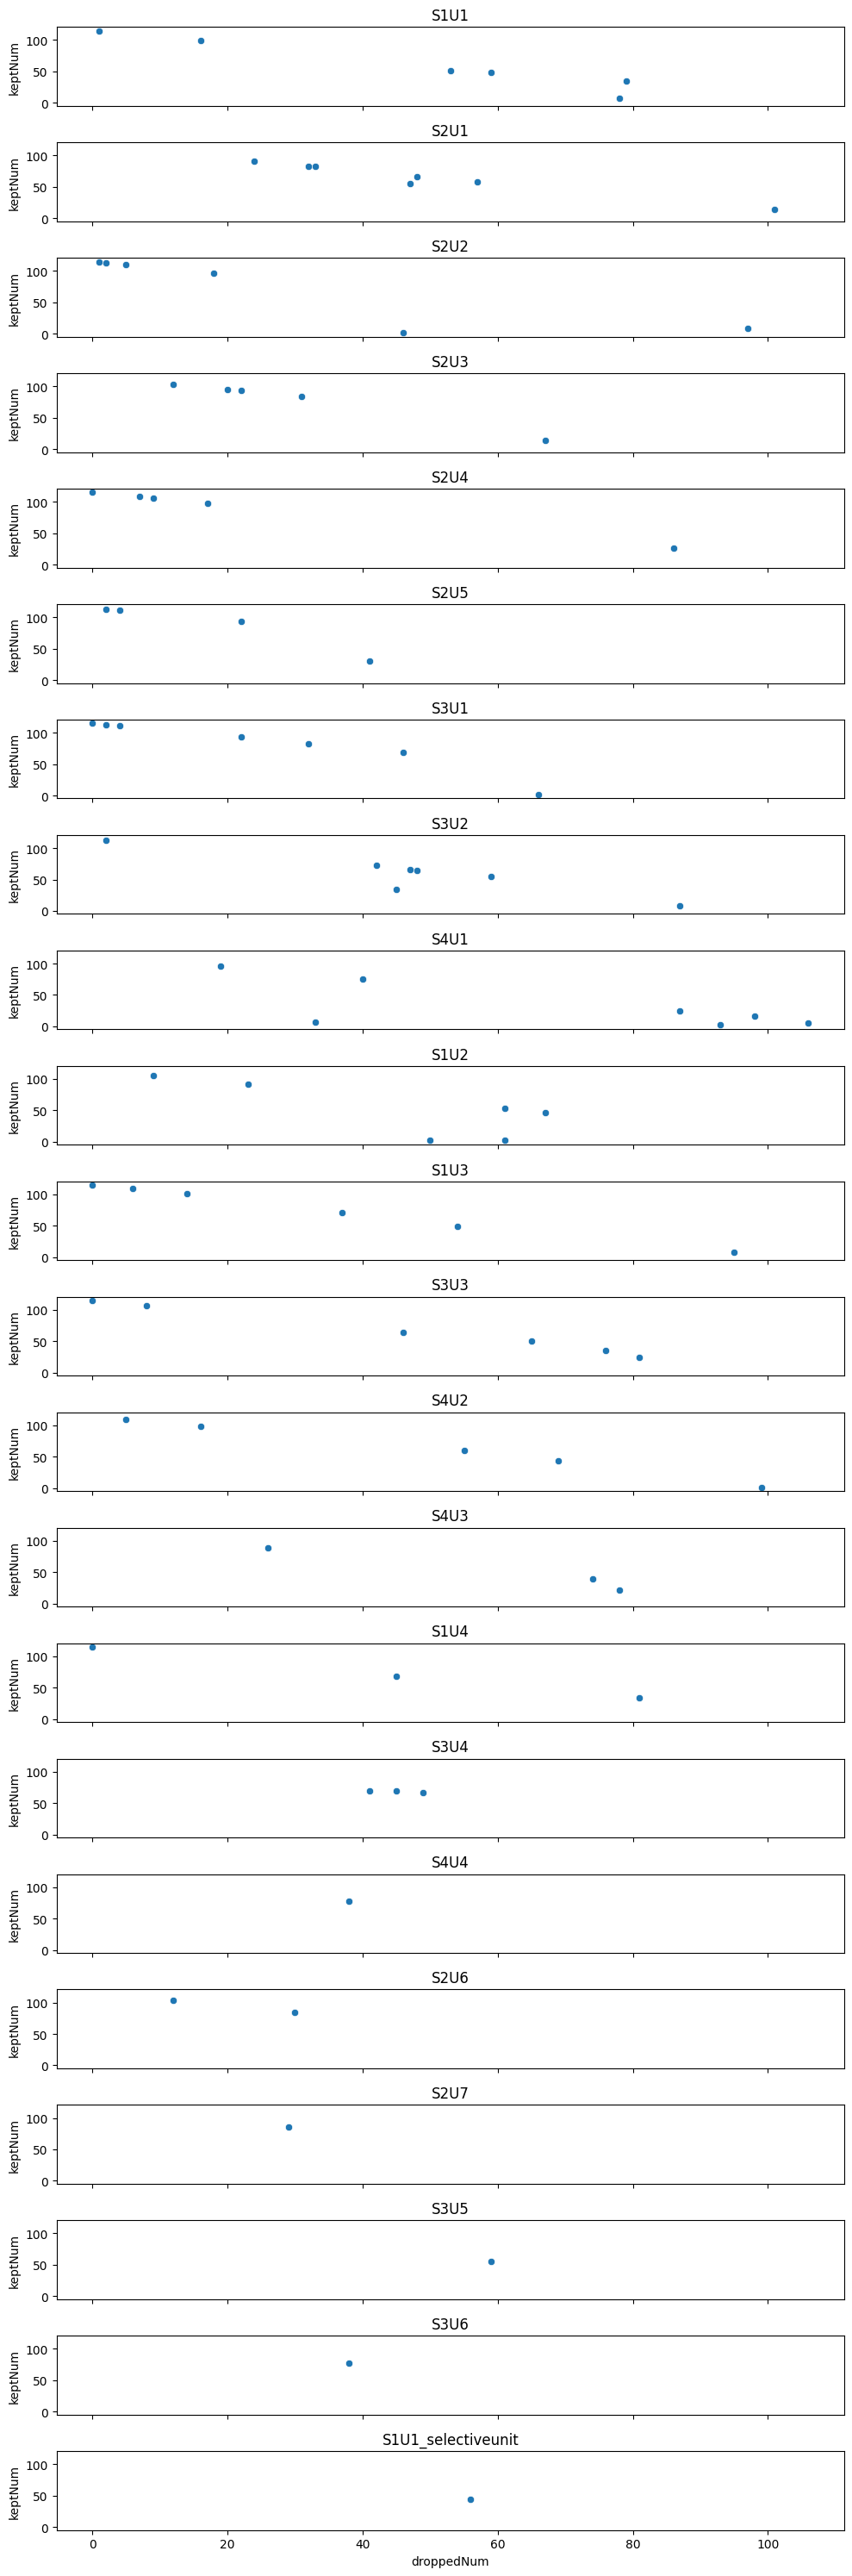

In [90]:
#unsupervised
def checkDroppedOrNot(mothNameLst,droppedDF,information):
    #read neuronName from mothName_pre_stim_cleaned.csv
    dir = os.getcwd()
    tmp = defaultdict(lambda: [])
    #load data from csv file
    for mothName in mothNameLst:
        loadPath =  os.path.join(dir,f'ALdata/{mothName}_pre_stim_cleaned.csv')
        csvDF = pd.read_csv(loadPath, header = 0)
        for neuronName in csvDF.columns[3:]:
            #print(f"mothName: {mothName}, neuronName: {neuronName}")
            droppedNum = np.count_nonzero((droppedDF['mothName'] == mothName) \
                                & (droppedDF['neuron'] == neuronName))
            #print(f"droppedNum: {droppedNum}")

            #count number of mothName = 070906 and neuron = S1U1 in information
            keptNum = np.count_nonzero((np.array(information)[:,2] == mothName) \
                                & (np.array(information)[:,1] == neuronName))
            #print(f"keptNum: {keptNum}")
            #print("#############")
            tmp[neuronName] += [[droppedNum,keptNum]]
    return tmp

#check whether given a neuron and a moth name, \
# either all points are dropped or all are kept
tmpDict = checkDroppedOrNot(mothNames,droppedDF,information)

#plot scatter points in tmpDict, with each neuron a unique color
fig, axs = plt.subplots(len(tmpDict), 1, figsize=(10, 30),\
                        sharex=True, sharey=True)
for i,key in enumerate(tmpDict.keys()):
    sns.scatterplot(x = np.array(tmpDict[key])[:,0],\
                    y = np.array(tmpDict[key])[:,1],ax = axs[i])
    axs[i].set_title(key)
    axs[i].set_xlabel('droppedNum')
    axs[i].set_ylabel('keptNum')
plt.tight_layout()
plt.show()

#savefig
fig.savefig('droppedOrNot.jpg',dpi = 300)

#it remains to answer whether a neuron name shares the same meaning among different moth names



In [53]:
#unsupervised -- save data into csv file
def saveData(Dataset,nameRes,neuronRes,stimuliRes):
    #load data from csv file
    savePath =  'unsupervised_learning/nine_parameters.csv'

    df = pd.DataFrame(Dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    df['Neuron'] = neuronRes
    df['Stimuli'] = stimuliRes
    
    df.to_csv(savePath, index=False)
    return df

df = saveData(sampleDataset,nameRes,neuronRes,stimuliRes)

In [54]:
display(df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Neuron,Stimuli
0,0.3123,16.010247,16.010247,5,0.0000,1.000000,1.055855,2.667008,2.667008,070906,S1U1,Lin
1,0.0817,85.679315,85.679315,7,0.0000,0.636364,2.891845,1.437158,1.437158,070906,S1U1,Lin
2,0.2256,17.730496,17.730496,4,0.0000,0.571429,1.001603,1.693433,1.693433,070906,S2U1,Lin
3,0.4526,19.885108,59.642147,9,0.3022,0.600000,3.015378,1.707957,2.172971,070906,S2U1,Lin
4,0.1283,23.382697,23.382697,3,0.0000,0.500000,1.760253,0.854179,0.854179,070906,S2U4,Lin
...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.0728,54.945055,54.945055,4,0.0000,0.363636,1.012556,1.515097,1.515097,071002,S3U3,Myr
279,0.3968,10.080645,10.080645,4,0.0000,0.800000,1.099505,1.415694,1.415694,071002,S3U3,Myr
280,0.1776,50.675676,50.675676,9,0.0000,0.642857,1.198466,2.008013,2.008013,071002,S3U3,Myr
281,0.6249,9.601536,11.574074,6,0.0381,1.000000,2.087465,0.943722,1.002738,071002,S3U3,Myr


In [18]:
def reductionClustering(sampleDF,reducedColumnNames,tailColumnNames,reductionFunc,reductionParams,clusteringFunc,clusteringParams,shuffleRandomState,isShuffle = True):
    #setup unsupervised classification training
    #shuffle sample dataset
    if isShuffle:
        sampleDF = shuffle(sampleDF,random_state=shuffleRandomState)

    #normalization
    sample = preprocessing.normalize(sampleDF.loc[:,reducedColumnNames])

    #dimensionality reduction
    reducedSample = reductionFunc(**reductionParams).fit_transform(sample)

    #normalization again
    #reducedSample = preprocessing.normalize(reducedSample)

    #KMeans classification
    clusteringModel = clusteringFunc(**clusteringParams)

    #fit clustering model
    clusteringModel.fit(reducedSample)


    #put last columns back to reducedSample and form new dataframe
    reducedSample = np.hstack((reducedSample,sampleDF.loc[:,tailColumnNames].to_numpy()))
    reducedSampleDF = pd.DataFrame(reducedSample,columns = ['PC1','PC2']+tailColumnNames)
    
    #add label to sample dataframes
    reducedSampleDF['pred_label'] = copy.deepcopy(clusteringModel.labels_)
    sampleDF['pred_label'] = copy.deepcopy(clusteringModel.labels_)
    

    return sampleDF,reducedSampleDF


#TSNE
TSNEparams = {'n_components':2,'random_state':42}

#KPCA
KPCAparams = {'n_components':2,'kernel':'linear'}

#KMeans
KMeansParams = {'n_clusters':2,'random_state':42}

In [ ]:
#Result
#unsupervised
reducedColumnNames = list(df.columns[:-3])
tailColumnNames = list(df.columns[-3:])
DF,reducedSampleDF = reductionClustering(df,reducedColumnNames,tailColumnNames,\
                                         KernelPCA,KPCAparams,\
                                            KMeans,KMeansParams,42,isShuffle = True)

Statistics Result Analysis

In [19]:
#extract numpy array from dataframe df with designated columns and subject default = 070921
#neglect the last two columns (subject and stimuli)
def extractNumpyArray(DF,lstColumnNames,subject):
    extractedDF = DF.loc[DF['Subject'] == subject]
    extractedDF = extractedDF.loc[:,lstColumnNames]
    return extractedDF


def classificationResultPlot(reducedSampleDF,lstColumnNames = ['PC1','PC2','pred_label'] ,subject = '070921'):
    #extract reducedSampleDF
    extractedReducedSampleDF = extractNumpyArray(reducedSampleDF,lstColumnNames,subject)
    #plotting according to kmeans clustering classification result
    fig,axs = plt.subplots(2,1,sharex = True,sharey = True,figsize=(15,15))

    axs[0].scatter(reducedSampleDF['PC1'],reducedSampleDF['PC2'],c=reducedSampleDF['pred_label'],cmap='rainbow')
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[0].set_title('KMeans classification result for total data')

    axs[1].scatter(extractedReducedSampleDF['PC1'],extractedReducedSampleDF['PC2'],c=extractedReducedSampleDF['pred_label'],cmap='rainbow')
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    axs[1].set_title('KMeans classification result for subject 070921')

    #plt.legend()
    plt.show()

    #plot according to subject

    #save figures
    fig.savefig('kmeans_2.png')

In [ ]:
classificationResultPlot(reducedSampleDF)

In [57]:
#give number of datapoints in each cluster
def numberDatapointsInClusters(DF):
    #group by label
    groupedDF = DF.groupby('pred_label')
    #count number of datapoints in each cluster
    countDF = groupedDF.count()
    return countDF

print(numberDatapointsInClusters(DF))

       burst duration  within-burst spiking freq  \
label                                              
0                 219                        219   
1                  64                         64   

       within-burst max spiking freq  within-burst number of spikes  \
label                                                                 
0                                219                            219   
1                                 64                             64   

       inter-burst interval  percentage of burst spikes  burst frequency  \
label                                                                      
0                       219                         219              219   
1                        64                          64               64   

       mean surprise  max surprise  Subject  Neuron  Stimuli  
label                                                         
0                219           219      219     219      219  
1           

In [20]:
def histoResults(DF,lstColumnNames,plotFunc,plotParams,saveFileName = 'unsupervised_learning/histograms.jpg',barplot = False):
    #3x3 subplots
    #fig,ax = plt.subplots(9,1,figsize=(15,15))
    fig = plt.figure(figsize=(15,15))
    #sns plot with hue of each of the nine parameters on a row for datapoints in each cluster
    for j in range(9):
        #use "y = " for barplot, "x = " otherwise
        #figure into the jth subplot
        if barplot:
            fig.add_subplot(3,3,j+1)
            plotFunc(data=DF,y=lstColumnNames[j],**plotParams)
        else:
            fig.add_subplot(3,3,j+1)
            plotFunc(data=DF,x=lstColumnNames[j],**plotParams)

        #ax[j].set_title(f'cluster {lstColumnNames[j]}')

    plt.show()
    fig.savefig(saveFileName)
    return

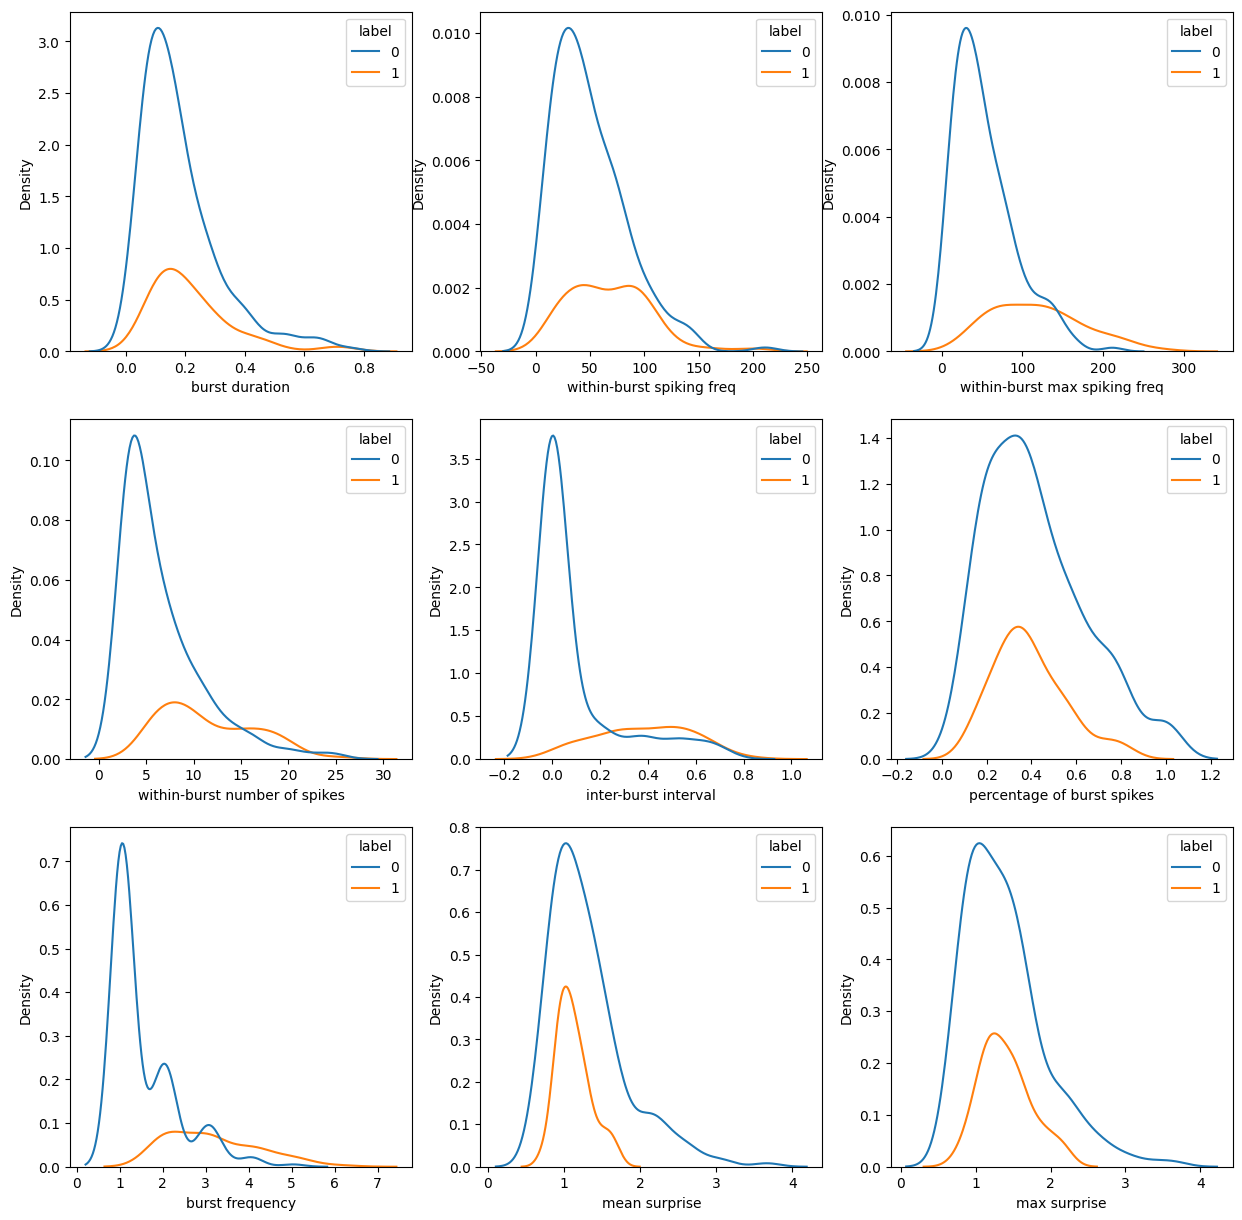

In [59]:
histoResults(DF,reducedColumnNames,sns.kdeplot,{'hue':'pred_label'},'unsupervised_learning/kdeplot.jpg')

In [22]:
#concatenate 50 random samples from df1 and df2 
def concatRandomSamples(DF,numSamples,N = 2,randomState = 42,label = 'pred_label'):
    #split dataframe by labels
    lstLabels = range(N)
    lstDF = ['']*len(lstLabels)
    for i in lstLabels:
        elementDF = DF.loc[DF[label] == i]
        #print(elementDF.shape)
        #randomly select 50 samples from each dataframe
        elementDF = elementDF.sample(n=numSamples,random_state = randomState)

        lstDF[i] = elementDF


    #concatenate dataframes
    df = pd.concat(lstDF,axis=0)
    return df


In [ ]:
concatDF = concatRandomSamples(DF,50)
print(concatDF)

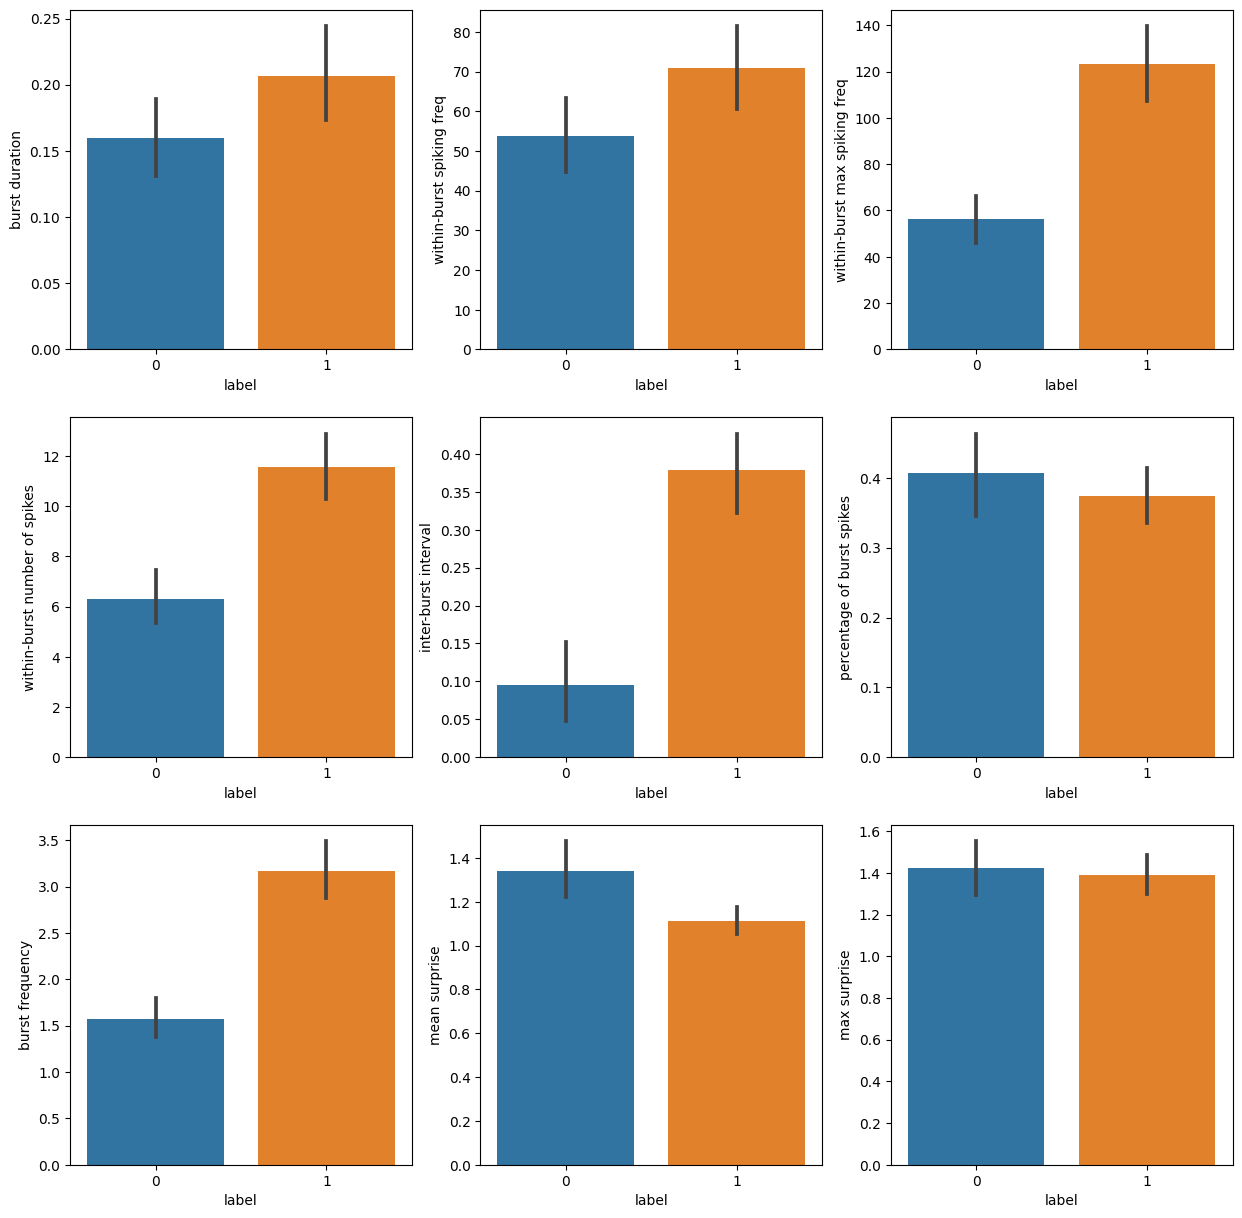

In [61]:
histoResults(concatDF,reducedColumnNames,\
                        sns.barplot,{'x':'pred_label'},'unsupervised_learning/barplot_50.jpg',barplot = True)

Read labeled data

In [23]:
#load nine_burst_parameters.csv from supervised learning directory
loadPath =  'supervised_learning/nine_burst_parameters.csv'

labeled_df = pd.read_csv(loadPath, header = 0)

In [24]:
display(labeled_df)

,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,label
0,0.40261,12.418966,12.418966,5,0.00000,0.217391,0.201957,1.192730,1.192730,60324124,0
1,0.26911,59.455241,59.455241,16,0.00000,0.092486,0.200605,1.257588,1.257588,71031002,0
2,0.02979,100.704935,100.704935,3,0.00000,0.010563,0.200198,3.615758,3.615758,71031005,0
3,0.41987,7.145069,7.145069,3,0.00000,0.176471,0.205084,1.146890,1.146890,60223175,1
4,1.18069,6.775699,12.555716,8,1.20391,0.250000,0.404303,1.373569,1.613699,60223174,1
5,1.00932,9.907661,25.980774,10,3.19860,0.384615,0.624064,1.050495,1.388560,60223176,1
6,0.76495,9.150925,9.671881,7,1.57373,0.212121,0.401039,1.093744,1.396758,60223173,1
7,0.90932,13.196674,23.822759,12,1.53128,0.387097,0.800096,0.903848,1.057262,60223172,1
8,0.26549,56.499303,56.499303,15,0.00000,0.092593,0.201020,1.311335,1.311335,71016215,1
9,0.28201,56.735577,62.214849,16,0.92125,0.104575,0.400860,0.935947,1.012572,71016216,1


In [25]:
labeled_reducedColumnNames = list(labeled_df.columns[:-2])
labeled_tailColumnNames = list(labeled_df.columns[-2:])
labeled_DF,labeled_reducedSampleDF = \
    reductionClustering(labeled_df,labeled_reducedColumnNames,\
                         labeled_tailColumnNames,\
                        KernelPCA,KPCAparams,\
                            KMeans,KMeansParams,42,isShuffle = True)

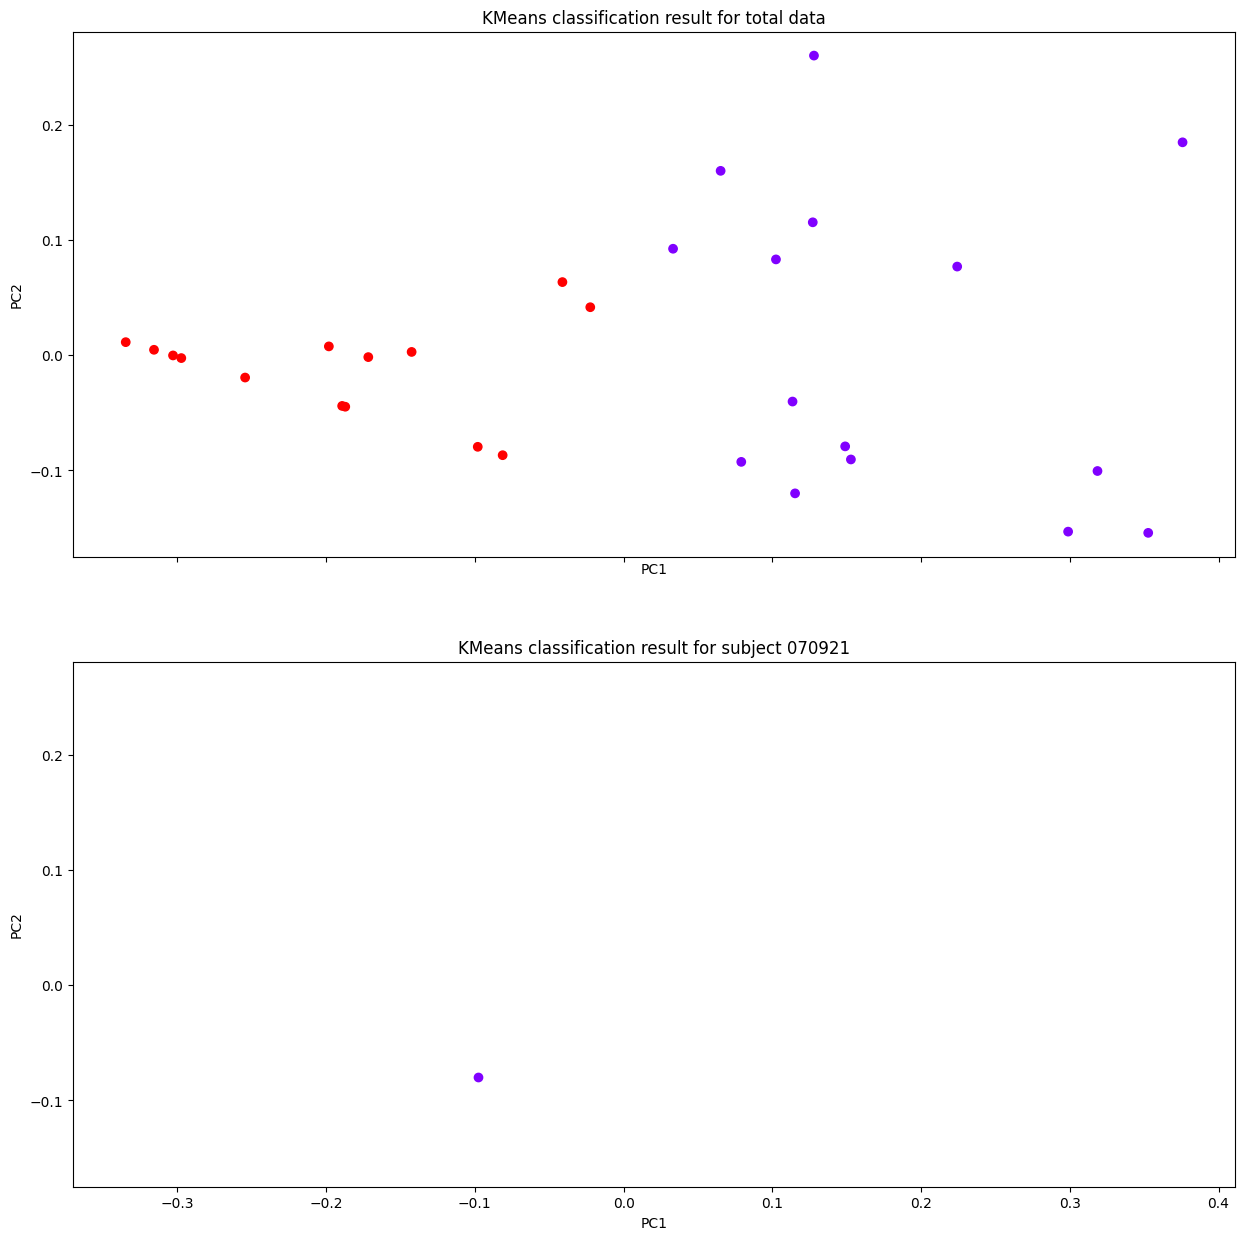

In [28]:
classificationResultPlot(labeled_reducedSampleDF,subject=60324124)

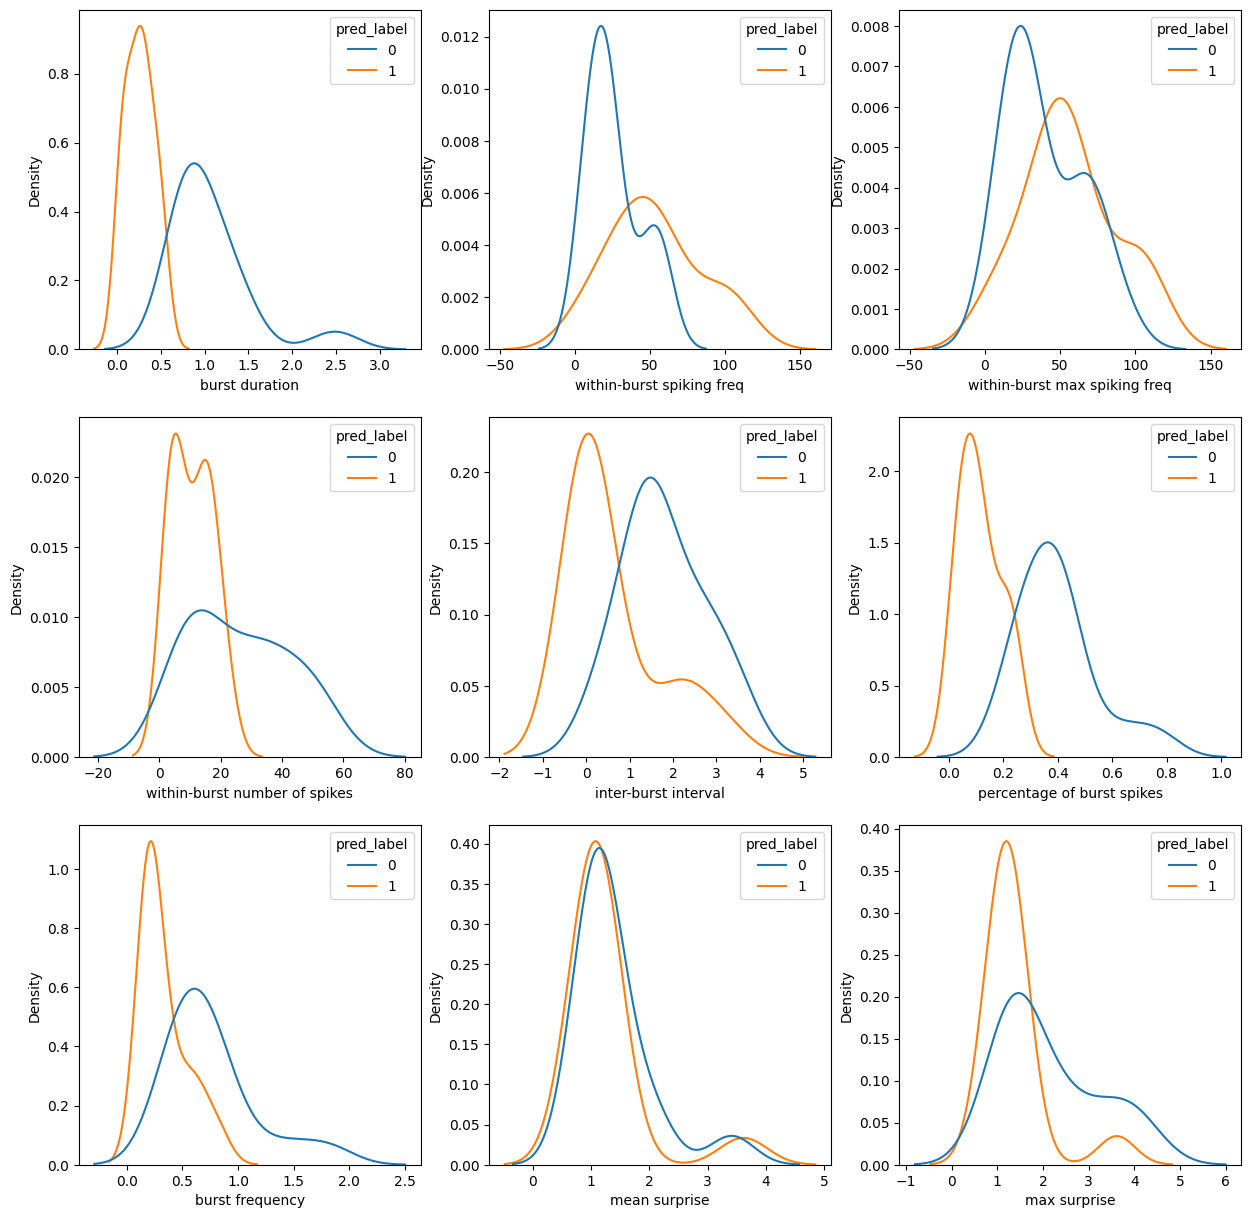

In [29]:
#kdeplot
histoResults(labeled_DF,labeled_reducedColumnNames,sns.kdeplot,{'hue':'pred_label'},'unsupervised_learning/labeled_kdeplot.jpg')

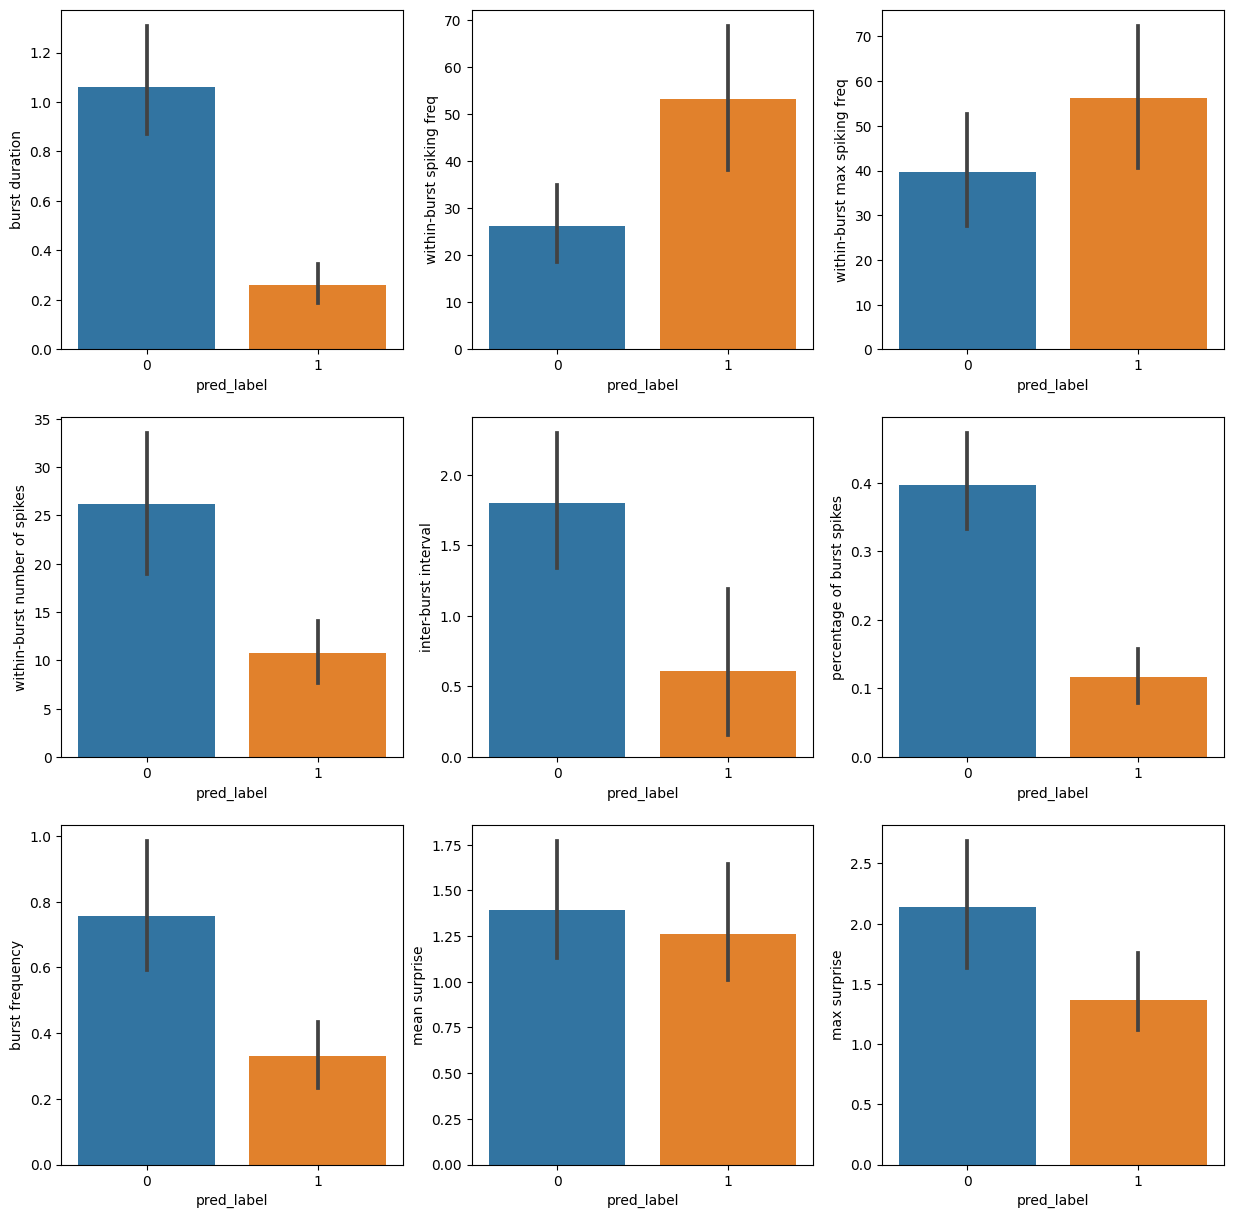

In [30]:
#histogram
histoResults(labeled_DF,labeled_reducedColumnNames,\
                        sns.barplot,{'x':'pred_label'},'unsupervised_learning/labeled_barplot.jpg',barplot = True)